# TRAPPIST-1 Corona Spectrum Modelled With Differential Emission Measure

The intrinsic specific intensity of a single emission line is:

$$I_{\lambda_{ul}} = \frac{1}{4\pi}\int_{\mathrm{Line-of-sight}} n_{u} A_{ul} \frac{hc}{\lambda_{ul}} ds$$

where $ul$ indicates a transition from an upper state $u$ to a lower state $l$, $\lambda_{ul}$ is the wavelength of the transition, $n_u$ is the number density of the emitting species in the upper state, and $A_{ul}$ is the Einstein rate coefficient of the transition.

By rewriting $n_u$:
$$n_u = \frac{n_u}{n_{\mathrm{ion}}}\frac{n_{\mathrm{ion}}}{n_{\mathrm{el}}}\frac{n_{\mathrm{el}}}{n_H}n_H$$
where $n_{\mathrm{el}}$ is the number density of the element of the species, we can construct a contribution function $G(T)$ that depends only on atomic data like the rate coefficient and transition wavelength, the ionization fraction, and elemental abundance.

This allows us to rewrite the intensity integral to be:
$$I_{\lambda_{ul}} = \int_{\mathrm{T}} G(T) \Psi (T) dT$$

where $\Psi (T) = n_e n_H \frac{ds}{dT} = $ the differential emission measure. $G(T)$ measures the contribution of material at a given temperature to the emitted intensity of a line while $\Psi (T)$ measures the amount of material that is present at a given temperature along the line of sight.

We have measured line intensities across a range of formation temperatures, allowing us to fit for $\Psi$ (assuming a continuous function, in this case a $4^{\mathrm{th}}$ order polynomial in loglogspace), and then calculate the expected intensities of lines across the entire wavelength range for which we expect this distribution to apply (i.e. the corona).

## Setting up required packages:

In [4]:
import numpy as np
import pandas as pd
import ChiantiPy.core as ch
from ChiantiPy.tools.io import masterListRead
import emcee
from astropy import units as u
from astropy import constants
from astropy.io import fits as pyf
from scipy.io import readsav
from numpy.polynomial.chebyshev import chebval, chebfit
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from multiprocessing import Pool

sns.set_style('whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Initialize all CHIANTI database ions to create the model spectrum

In [5]:
def initialize_ion(ion):
    ion.intensity()
    return ion


def generate_ion_intensity_list(temp=np.logspace(4.0, 8.0, 120),
                                dens=10.0**7.0,
                                abund_file='sun_coronal_2012_schmelz_ext'):
    """Initialize all available ChiantiPy ions and generate the Emissivity.

    Keyword arguments:
    :param temp: The array of temperature values to pass when creating the
    ChiantiPy ions. (default np.logspace(4.0, 8.0, 120))
    :type temp: np.ndarray.

    :param dens: The value of density to pass when creating the ChiantiPy ions.
    (default 10.0**11.0)
    :type dens: float.

    :param abund_file: The string with the name of the abundance file for ChiantiPy
    to query when creating the ions. (default sun_coronal_2012_schmelz_ext)
    :type abund_file: str.

    Returns:
    :returns ions: list -- list of ChiantiPy ions.

    """

    ion_names = masterListRead()
    ions = [initialize_ion(ch.ion(ion_name, temperature=temp, eDensity=dens, abundance=abund_file))
            for ion_name in ion_names]
    return ions

## Generate contribution functions for Ions from Line Flux CSV

In [6]:
def generate_line_intensities(temp, dens=10.0**7.0,
                                abund_file='sun_coronal_2012_schmelz_ext',
                                abundance=0.04):
    si3_intensity = 3.3e-17
    si3_err = 0.3e-17

    si2_intensity = 2.2e-17
    si2_err = 0.3e-17
    


    c2_intensity = (3.20e-17) + (5.37e-17)
    c2_err = np.sqrt((0.51e-17)**2.0 + (0.8e-17)**2.0)
    
    c3_intensity = 6e-17
    c3_err = 0.2e-17

    c4_intensity = (10.8e-17) + (4.39e-17)
    c4_err = np.sqrt((0.9e-17)**2.0 + (0.67e-17)**2.0)

    n5_intensity = (4.35e-17) + (2.31e-17)
    n5_err = np.sqrt((0.7e-17)**2.0 + (0.88e-17)**2.0)

    ion_intensities = [si3_intensity,
                       si2_intensity,
                       c2_intensity,
                       c3_intensity,
                       c4_intensity,
                       n5_intensity]

    ion_errs = [si3_err,
                si2_err,
                c2_err,
                c3_err,
                c4_err,
                n5_err]

    ion_intensities = np.array(ion_intensities)
    ion_errs = np.array(ion_errs)
    ion_errs[np.where(ion_errs <= 0.1 * ion_intensities)] = 0.1 * \
        ion_intensities[np.where(ion_errs <= 0.1 * ion_intensities)]

    c2 = ch.ion('c_2', temperature=temp, eDensity=dens, abundance=abund_file)
    c3 = ch.ion('c_3', temperature=temp, eDensity=dens, abundance=abund_file)
    c4 = ch.ion('c_4', temperature=temp, eDensity=dens, abundance=abund_file)

    si3 = ch.ion('si_3', temperature=temp, eDensity=dens, abundance=abund_file)
    si2 = ch.ion('si_2', temperature=temp, eDensity=dens, abundance=abund_file)

    n5 = ch.ion('n_5', temperature=temp, eDensity=dens, abundance=abund_file)

    c4.intensity()
    c3.intensity()
    c2.intensity()

    si3.intensity()
    si2.intensity()

    n5.intensity()

    line_max = 10

    c4_mean = np.mean(c4.Emiss['emiss'], axis=1)
    sorted_wvl = c4.Emiss['wvl'][np.argsort(c4_mean)[::-1]]
    range_wvl = sorted_wvl[np.where((sorted_wvl >= 1547.0) & (sorted_wvl <= 1552.0))]
    c4_idx = [np.where(c4.Emiss['wvl'] == i)[0][0] for i in range_wvl]
    print('C IV lines:', c4.Emiss['wvl'][c4_idx][0:line_max])

    c3_mean = np.mean(c3.Emiss['emiss'], axis=1)
    sorted_wvl = c3.Emiss['wvl'][np.argsort(c3_mean)[::-1]]
    range_wvl = sorted_wvl[np.where((sorted_wvl >= 1173) & (sorted_wvl <= 1177))]
    c3_idx = [np.where(c3.Emiss['wvl'] == i)[0][0] for i in range_wvl]
    print('C III lines:', c3.Emiss['wvl'][c3_idx][0:line_max])

    c2_mean = np.mean(c2.Emiss['emiss'], axis=1)
    sorted_wvl = c2.Emiss['wvl'][np.argsort(c2_mean)[::-1]]
    range_wvl = sorted_wvl[np.where((sorted_wvl >= 1333) & (sorted_wvl <= 1337))]
    c2_idx = [np.where(c2.Emiss['wvl'] == i)[0][0] for i in range_wvl]
    print('C II lines:', c2.Emiss['wvl'][c2_idx][0:line_max])

    si3_mean = np.mean(si3.Emiss['emiss'], axis=1)
    sorted_wvl = si3.Emiss['wvl'][np.argsort(si3_mean)[::-1]]
    range_wvl = sorted_wvl[np.where((sorted_wvl >= 1206) & (sorted_wvl <= 1208))]
    si3_idx = [np.where(si3.Emiss['wvl'] == i)[0][0] for i in range_wvl]
    print('Si III lines:', si3.Emiss['wvl'][si3_idx][0:line_max])

    si2_mean = np.mean(si2.Emiss['emiss'], axis=1)
    sorted_wvl = si2.Emiss['wvl'][np.argsort(si2_mean)[::-1]]
    range_wvl = sorted_wvl[np.where((sorted_wvl >= 1526) & (sorted_wvl <= 1528))]
    si2_idx = [np.where(si2.Emiss['wvl'] == i)[0][0] for i in range_wvl]
    print('Si II lines:', si2.Emiss['wvl'][si2_idx][0:line_max])

    n5_mean = np.mean(n5.Emiss['emiss'], axis=1)
    sorted_wvl = n5.Emiss['wvl'][np.argsort(n5_mean)[::-1]]
    range_wvl = sorted_wvl[np.where((sorted_wvl >= 1237) & (sorted_wvl <= 1245))]
    n5_idx = [np.where(n5.Emiss['wvl'] == i)[0][0] for i in range_wvl]
    print('N V lines:', n5.Emiss['wvl'][n5_idx][0:line_max])

    si3_gofnt = (si3.Abundance * si3.IoneqOne / si3.EDensity)
    si3_gofnt *= 10.0**(abundance)
    si3_gofnt *= np.sum(si3.Emiss['emiss'][si3_idx][0:], axis=0)
    si3_temp_f = np.log10(temp[np.argmax(si3_gofnt)])

    si2_gofnt = (si2.Abundance * si2.IoneqOne / si2.EDensity)
    si2_gofnt *= 10.0**(abundance)
    si2_gofnt *= np.sum(si2.Emiss['emiss'][si2_idx][0:], axis=0)
    si2_temp_f = np.log10(temp[np.argmax(si2_gofnt)])

    c2_gofnt = (c2.Abundance * c2.IoneqOne / c2.EDensity)
    c2_gofnt *= 10.0**(abundance)
    c2_gofnt *= np.sum(c2.Emiss['emiss'][c2_idx][0:], axis=0)
    c2_temp_f = np.log10(temp[np.argmax(c2_gofnt)])

    c3_gofnt = (c3.Abundance * c3.IoneqOne / c3.EDensity)
    c3_gofnt *= 10.0**(abundance)
    c3_gofnt *= np.sum(c3.Emiss['emiss'][c3_idx][0:], axis=0)
    c3_temp_f = np.log10(temp[np.argmax(c3_gofnt)])

    c4_gofnt = (c4.Abundance * c4.IoneqOne / c4.EDensity)
    c4_gofnt *= 10.0**(abundance)
    c4_gofnt *= np.sum(c4.Emiss['emiss'][c4_idx][0:], axis=0)
    c4_temp_f = np.log10(temp[np.argmax(c4_gofnt)])

    n5_gofnt = (n5.Abundance * n5.IoneqOne / n5.EDensity)
    n5_gofnt *= 10.0**(abundance)
    n5_gofnt *= np.sum(n5.Emiss['emiss'][n5_idx][0:], axis=0)
    n5_temp_f = np.log10(temp[np.argmax(n5_gofnt)])

    ion_gofnts = [si3_gofnt, si2_gofnt,
                  c2_gofnt, c3_gofnt,
                  c4_gofnt, n5_gofnt]

    ion_temp_fs = [si3_temp_f, si2_temp_f,
                   c2_temp_f, c3_temp_f,
                   c4_temp_f, n5_temp_f]

    ion_gofnts = np.array(ion_gofnts)
    ion_temp_fs = np.array(ion_temp_fs)

    return ion_intensities, ion_errs, ion_gofnts, ion_temp_fs

## Create a matrix that adds up contribution functions for all ions at each temperature

In [7]:
def get_gofnt_matrix(ions, wave_arr,
                     temp, abundance):
    """Create a matrix where the first axis is the array of wavelength bins
    within which to look for emission lines, while the second is the temperature
    array used for the ChiantiPy ions. The matrix contains contribution
    functions evaluated for all lines within a bin over the full temperature
    array.

    Keyword arguments:
    :param ions: List containing all ChiantiPy ions for which
    contribution functions should be evaluated.
    :type ions: list.

    :param wave_arr: Array of the wavelength bin centers for which to evaluate
    contribution functions.
    :type wave_arr: np.ndarray.

    :param temp: Array of temperatures for which the ChiantiPy emissivities have
    been evaluated.
    :type temp: np.ndarray.

    :param abundance: [Fe/H] abundance to weight the contribution functions by.
    (default 0.0)
    :type abundance: float.

    Returns:
    :returns: np.ndarray -- Contribution function matrix.

    """

    bin_width = np.diff(wave_arr)
    bin_width = np.append([bin_width[0]], bin_width)
    gofnt_matrix = np.zeros((len(wave_arr), len(temp)))
    for ion in ions:
        gofnt_prefactor = ion.Abundance * ion.IoneqOne / ion.EDensity
        if ion.Z > 2.0:
            gofnt_prefactor *= 10.0**abundance
        for i in range(0, len(wave_arr)):
            wave_low = wave_arr[i] - 0.5 * bin_width[i]
            wave_high = wave_arr[i] + 0.5 * bin_width[i]
            bin_mask = np.where((ion.Emiss['wvl'] <= wave_high) & (ion.Emiss['wvl'] > wave_low))[0]
            for line in bin_mask:
                gofnt_matrix[i, :] += gofnt_prefactor * \
                    ion.Emiss['emiss'][line]
    return gofnt_matrix

## Calculate the expected intensity for a given G(T) and $\Psi(T)$

In [8]:
def do_gofnt_matrix_integral(psi_model,
                             gofnt_matrix,
                             temp,
                             flux_weighting):
    """Evaluate the line intensity integrals for each wavelength bin using the
    contribution function matrix and a given DEM model.

    Keyword arguments:
    :param psi_model: DEM model for the integral
    :type psi_model: np.ndarray.

    :param gofnt_matrix: Contribution function matrix
    :type gofnt_matrix: np.ndarray.

    :param temp: Array of temperatures along same axis as the DEM model, the
    ChiantiPy emissivities, and the second axis of the contribution function
    matrix.
    :type temp: np.ndarray.

    :param flux_weighting: Weight the intensity integral to map to some observable
    or desired quantity (flux received by exoplanet, surface flux of star etc.)
    :type flux_weighting: float.

    Returns:
    :returns: np.ndarray -- Total flux intensities in each wavelength bin.

    """

    integrated_intensity_array = np.zeros((np.shape(gofnt_matrix)[0]))
    for i in np.arange(0, len(integrated_intensity_array)):
        integrated_intensity_array[i] = np.trapz(
            gofnt_matrix[i, :] * psi_model, temp) * (flux_weighting)
    return integrated_intensity_array

## Integrate all flux within wavelength bins

In [9]:
def get_bin_integral(wave_arr, flux_arr,
                     err_arr,
                     bin_width):
    """Integrate the spectrum within bins of fixed width, mitigating dependence
    on instrument resolution and line shape to compare spectra (either observed
    or model generated).
    Keyword arguments:
    :param wave_arr: Wavelength array of original spectrum.
    :type wave_arr: np.ndarray.
    :param flux_arr: Flux array (in units of flux/wavelength) of original
    spectrum.
    :type flux_arr: np.ndarray.
    :param err_arr: Flux uncertainty array (in units of flux/wavelength) of original
    spectrum.
    :type err_arr: np.ndarray.
    :param bin_width: Size of wavelength bin to integrate spectrum within,
    in the same units as the original spectrum's wavelength array.
    :type bin_width: float.
    Returns:
    :returns: np.ndarray -- Wavelength array with bin centers.
    :returns: np.ndarray -- Integrated flux within each bin.
    :returns: np.ndarray -- Uncertainties of integrated flux within each bin
    """

    new_wave = np.arange(np.min(wave_arr),
                         np.max(wave_arr) + 0.5 * bin_width, bin_width)
    old_var = err_arr**2.0
    new_flux = np.empty_like(new_wave)
    new_var = np.empty_like(new_wave)
    for i in range(0, len(new_wave)):
        wave_mask = np.where((wave_arr >= new_wave[i] - 0.5*bin_width) & (wave_arr < new_wave[i] + 0.5*bin_width))
        new_flux[i] = np.trapz(flux_arr[wave_mask], wave_arr[wave_mask])
        new_var[i] = np.trapz(old_var[wave_mask], wave_arr[wave_mask])
    new_err = np.sqrt(new_var)
    return new_wave, new_flux, new_err

## Define appropriate likelihood function for MCMC sampler

In [10]:
def ln_prior_log_uniform(coeffs):
    """Apply a log-uniform prior between 10**+/- 5 for coefficients used in
    Chebyshev polynomial model for DEM.

    Keyword arguments:
    :param coeffs: List of coefficients for Chebyshev polynomial in format used by
    numpy chebyshev polynomial.
    :type coeffs: list.

    Returns:
    :returns: float -- 0 if prior is satisfied, -np.inf otherwise.

    """

    lp = 0.0
    for coeff in coeffs:
        if coeff >= -10.0**25.0:
            if coeff <= 10.0**25.0:
                lp += 0.0
            else:
                return -np.inf
        else:
            return -np.inf
    if lp > 0.0:
        return -np.inf
    return lp


def ln_prob(coeffs, y,
            yerr,
            log_temp,
            temp,
            gofnt_matrix,
            flux_weighting):
    """Evaluate the -1/2 chi-squared comparing the measured intensities of
    observed spectra to the DEM integrated intensities.

    Keyword arguments:
    :param coeffs: List of coefficients for Chebyshev polynomial in format used by
    numpy chebyshev polynomial.
    :type coeffs: list.

    :param y: Bin-integral of observed spectrum.
    :type y: np.ndarray.

    :param yerr: Error on y, either an array or constant float.
    :type yerr: Union[np.ndarray, float].

    :param log_temp: log10(Temperature  array for ChiantiPy emissivities)
    :type log_temp: np.ndarray.

    :param temp: Temperature array for ChiantiPy emissivities.
    :type temp: np.ndarray.

    :param gofnt_matrix: Contribution matrix along ions and
    temperature arrays.
    :type gofnt_matrix: np.ndarray.

    :param flux_weighting: Weight the intensity integral to map to some observable
    or desired quantity (flux received by exoplanet, surface flux of star etc.)
    :type flux_weighting: float.

    Returns:
    :returns: float -- -1/2 Chi-squared

    """

    psi_model = 10.0**chebval(log_temp, coeffs)
    if np.nanmin(psi_model) <= 0.0:
        return -np.inf
    model = do_gofnt_matrix_integral(psi_model, gofnt_matrix,
                                     temp, flux_weighting)
    val = -0.5 * (np.sum(((y) - (model))**2 / (yerr**2)))
    if np.isfinite(val):
        return val
    return -np.inf


def ln_likelihood(coeffs,
                  y,
                  yerr,
                  log_temp, temp,
                  gofnt_matrix,
                  flux_weighting,
                  ln_prob_func=ln_prob,
                  ln_prior_func=ln_prior_log_uniform):
    """Combine a defined prior and probability function to determine the
    ln_likelihood of a model given two types of data: the bin-integral of an
    observed spectrum or the intensities of individual lines.

    Keyword arguments:
    :param coeffs: List of coefficients for Chebyshev polynomial in format used by
    numpy chebyshev polynomial.
    :type coeffs: list.

    :param y: Bin-integral of observed spectrum.
    :type y: np.ndarray.

    :param yerr: Error on y, either an array or constant float.
    :type yerr: Union[np.ndarray, float].

    :param log_temp: log10(Temperature  array for ChiantiPy emissivities)
    :type log_temp: np.ndarray.

    :param temp: Temperature array for ChiantiPy emissivities.
    :type temp: np.ndarray.

    :param wave_arr: Wavelength array with bin centers.
    :type wave_arr: np.ndarray.

    :param gofnt_matrix: Contribution matrix along wavelength bin and
    temperature arrays.
    :type gofnt_matrix: np.ndarray.

    :param flux_weighting: Weight the intensity integral to map to some observable
    or desired quantity (flux received by exoplanet, surface flux of star etc.)
    :type flux_weighting: float.


    Returns:
    :returns: float -- ln_likelihood from comparing bin integral of observed
    spectrum to DEM integrated spectrum or individual line intensities to DEM
    integrated line intensities.

    """

    lp = ln_prior_func(coeffs)
    if lp == 0.0:
        return lp + ln_prob_func(coeffs, y, yerr, log_temp, temp,
                                 gofnt_matrix, flux_weighting)
    return -np.inf


def get_init_cheby_guess(log_temp, degree=4):
    """Get an initial fit Chebyshev Polynomial for the DEM.

    Keyword arguments:
    :param log_temp: log10(Temperature used for DEM fitting)
    :type log_temp: np.ndarray

    Returns:
    :returns: np.ndarray -- Chebyshev polynomial coefficients for
    numpy.polynomial.chebval to evaluate.

    """

    return chebfit(log_temp, 21.0 * np.ones_like(log_temp), deg=degree)


def fit_emcee(init_pos,
              likelihood_func,
              likelihood_args,
              n_walkers,
              burn_in_steps,
              production_steps,
              init_spread=1e-3,
              second_spread=1e-4,
              double_burn=True,
              thread_num=multiprocessing.cpu_count(),
              count_print=True,
              count_num=100):
    """Run the emcee sampler with a given likelihood function
    and return the flatchain samples, flatchain ln_probability, and the sampler
    object.

    Keyword arguments:
    :param init_pos: Initial values for the model parameters.
    : type init_pos: np.ndarray.

    :param likelihood_func: Likelihood function for the model.
    :type likelihood_func: function.

    :param likelihood_args: Arguments required for the likelihood function.
    :type likelihood_args: list.

    :param zxn_walkers: Number of walkers for the emcee sampler.
    :type n_walkers: int.

    :param burn_in_steps: Number of steps for the burn-in phase.
    :type burn_in_steps: int.

    :param production_steps: Number of steps for the production phase.
    :type production_steps: int.

    :param init_spread: Multiplicative factor by which to scramble the initial
    position of the walkers. (default 1e-3)
    :type init_spread: float.

    :param second_spread: Multiplicative factor by which to scramble the
    highest likelihood position after the burn-in phase. (default 1e-4)
    :type second_spread: float.

    :param double_burn: Whether or not to do a second burn-in phase. Treated
    identically to the initial. (default True)
    :type double_burn: bool

    :param thread_num: Number of threads for the emcee sampler to use.
    (default cpu_count)
    :type thread_num: int.

    :param count_print: Whether or not to print progress messages during
    production.
    :type count_print: bool.

    :param count_num: Interval for print messages.
    :type count_num: int.

    Returns:
    :returns: np.ndarray -- Reshaped sampler positions, collapsed along walker
    axis (see emcee documentation).

    :returns: np.ndarray -- ln_probability values for walker positions aligned
    to the flatchain.

    :returns: emcee.sampler -- emcee sampler object, refer to emcee
    documentation.

    """

    ndim = len(init_pos)
    pos = [init_pos + init_spread * np.random.randn(ndim) * init_pos
           for i in range(n_walkers)]
    sampler = emcee.EnsembleSampler(n_walkers, ndim, likelihood_func,
                                    args=likelihood_args, threads=thread_num)
    print("Starting burn-in")
    p0, prob, _ = sampler.run_mcmc(pos, burn_in_steps)
    p0 = [p0[np.argmax(prob)] + second_spread * np.random.randn(ndim) * p0[np.argmax(prob)] for i in range(n_walkers)]
    sampler.reset()
    nsteps = burn_in_steps + production_steps
    done_steps = burn_in_steps
    if double_burn:
        print("Starting second burn-in")
        nsteps += burn_in_steps
        done_steps += burn_in_steps
        p0, prob, _ = sampler.run_mcmc(p0, burn_in_steps)
        p0 = [p0[np.argmax(prob)] + second_spread * np.random.randn(ndim) * p0[np.argmax(prob)] for i in range(n_walkers)]
        sampler.reset()
    print("Starting production")
    if count_print:
        for i, result in enumerate(sampler.sample(p0,
                                                  iterations=production_steps)):
            if (i + 1) % count_num == 0:
                print("{0:5.1%}".format(float(i + done_steps) / nsteps))
    else:
        p0, prob, _ = sampler.run_mcmc(p0, production_steps)
    return sampler.flatchain, sampler.flatlnprobability, sampler

## Setup Target Stellar Parameters and convert intensity to flux

In [11]:
targ_dist = 12.49 * u.pc
targ_rad = 0.121 * u.R_sun
targ_abundance = 0.04
flux_unit = u.erg / (u.second * (u.cm**2.0))
intensity_conversion = (targ_dist**2.0) / ((targ_rad**2.0) * np.pi * u.sr)
intensity_unit = u.erg / (u.second * u.sr * (u.cm**2.0))
flux_weighting = ((np.pi * u.sr * (targ_rad**2.0) * (1.0 / (targ_dist**2.0))).to(u.sr)).value

## Setup temperature array, initial guess for Psi, wavelength array for model spectrum

In [12]:
temp = np.linspace(10.0**4.0, 10.0**6.5, 1500)
log_temp = np.log10(temp)
cheb_init = get_init_cheby_guess(log_temp, degree=4)
all_wave = np.arange(1.0, 2001.0, 5.0)
wave_lows = [0, 100, 1000]
wave_highs = [100, 1000, 2000]

## Get X-ray intensities and errors

In [10]:
xray_fits = pyf.open('Trappist-1.fits')
xray_wave = np.array([xray_fits[1].data[i][0] for i in range(0, 8)])
xray_flux = np.array([xray_fits[1].data[i][6] for i in range(0, 8)])
xray_err = np.array([xray_fits[1].data[i][7] for i in range(0, 8)])
xray_fits.close()

## Get FUV intensities and errors

In [11]:
trap_sav1 = readsav('TRAPPIST1_G130M_Mm1_NOSCL_10dec2018.sav')
trap_sav2 = readsav('TRAPPIST1_G160M_3orb_Mm1_NOSCL_09dec2018.sav')

fuv_wave1 = trap_sav1['wave']
fuv_wave2 = trap_sav2['wave']

fuv_flux1 = trap_sav1['flux']
fuv_flux2 = trap_sav2['flux']

fuv_err1 = trap_sav1['err']
fuv_err2 = trap_sav2['err']

mask1 = np.where((fuv_flux1 > 1e-16) & (fuv_wave1 >= 1290.0) & (fuv_wave1 < 1420))
mask2 = np.where((fuv_flux2 > 1e-16) & (fuv_wave2 >= 1420.0) & (fuv_wave2 <= 1500))
# xray_mask = np.where(xray_flux > 1e-17)

fuv_wave1, fuv_flux1, fuv_err1 = get_bin_integral(fuv_wave1[mask1], fuv_flux1[mask1], fuv_err1[mask1], 2.0)
fuv_wave2, fuv_flux2, fuv_err2 = get_bin_integral(fuv_wave2[mask2], fuv_flux2[mask2], fuv_err2[mask2], 2.0)
fuv_wave = np.append(fuv_wave1, fuv_wave2)
fuv_flux = np.append(fuv_flux1, fuv_flux2)
fuv_err = np.append(fuv_err1, fuv_err2)

wave_sort = np.argsort(fuv_wave)
fuv_err = fuv_err[wave_sort]
fuv_flux = fuv_flux[wave_sort]
fuv_wave = fuv_wave[wave_sort]

## Get Line Intensities and errors

In [12]:
'''
ion_intensities, ion_errs, ion_gofnts, ion_temp_fs = generate_line_intensities(temp)
np.save('ion_intensities', ion_intensities)
np.save('ion_errs', ion_errs)
np.save('ion_gofnts', ion_gofnts)
np.save('ion_temp_fs', ion_temp_fs)
'''

"\nion_intensities, ion_errs, ion_gofnts, ion_temp_fs = generate_line_intensities(temp)\nnp.save('ion_intensities', ion_intensities)\nnp.save('ion_errs', ion_errs)\nnp.save('ion_gofnts', ion_gofnts)\nnp.save('ion_temp_fs', ion_temp_fs)\n"

## Generate and save required contribution function matrices

In [13]:
'''
ions = generate_ion_intensity_list(temp)

gofnt_matrix_all = get_gofnt_matrix(ions, all_wave, temp, abundance=targ_abundance)
np.save('gofnt_matrix_all_trappist-1', gofnt_matrix_all)

gofnt_xray = get_gofnt_matrix(ions, xray_wave, temp, abundance=targ_abundance)
np.save('gofnt_xray', gofnt_xray)

gofnt_fuv = get_gofnt_matrix(ions, fuv_wave, temp, abundance=targ_abundance)
np.save('gofnt_fuv', gofnt_fuv)
'''

"\nions = generate_ion_intensity_list(temp)\n\ngofnt_matrix_all = get_gofnt_matrix(ions, all_wave, temp, abundance=targ_abundance)\nnp.save('gofnt_matrix_all_trappist-1', gofnt_matrix_all)\n\ngofnt_xray = get_gofnt_matrix(ions, xray_wave, temp, abundance=targ_abundance)\nnp.save('gofnt_xray', gofnt_xray)\n\ngofnt_fuv = get_gofnt_matrix(ions, fuv_wave, temp, abundance=targ_abundance)\nnp.save('gofnt_fuv', gofnt_fuv)\n"

## Load previously saved quantities

In [14]:
gofnt_xray = np.load('gofnt_xray.npy')
gofnt_fuv = np.load('gofnt_fuv.npy')
ion_intensities = np.load('ion_intensities.npy')
ion_errs = np.load('ion_errs.npy')
ion_gofnts = np.load('ion_gofnts.npy')
ion_temp_fs = np.load('ion_temp_fs.npy')

## Create single list of intensities, errors, contribution matrix

In [15]:
append_flux = np.append(xray_flux, ion_intensities)
append_errs = np.append(xray_err, ion_errs)
append_gofnt = np.append(gofnt_xray, ion_gofnts, axis=0)

## Run MCMC sampler to fit $\Psi (T)$ and save sampler parameters

In [16]:
'''
samples, lnprob, sampler = fit_emcee(init_pos=cheb_init,
                                     likelihood_func=ln_likelihood,
                                     likelihood_args=[append_flux,
                                                      append_errs,
                                                      log_temp,
                                                      temp,
                                                      append_gofnt,
                                                      flux_weighting,],
                                     n_walkers=100, burn_in_steps=15000,
                                     production_steps=50000,
                                     thread_num=multiprocessing.cpu_count(),
                                     count_print=True,
                                     count_num=10000)
np.save('samples_line_all', samples)
np.save('lnprob_line_all', lnprob)
'''

"\nsamples, lnprob, sampler = fit_emcee(init_pos=cheb_init,\n                                     likelihood_func=ln_likelihood,\n                                     likelihood_args=[append_flux,\n                                                      append_errs,\n                                                      log_temp,\n                                                      temp,\n                                                      append_gofnt,\n                                                      flux_weighting,],\n                                     n_walkers=100, burn_in_steps=15000,\n                                     production_steps=50000,\n                                     thread_num=multiprocessing.cpu_count(),\n                                     count_print=True,\n                                     count_num=10000)\nnp.save('samples_line_all', samples)\nnp.save('lnprob_line_all', lnprob)\n"

## Load sampler parameters

In [17]:
line_samples = np.load('samples_line_all.npy')
line_lnprob = np.load('lnprob_line_all.npy')
gofnt_matrix_all = np.load('gofnt_matrix_all_trappist-1.npy')

## Setup plotting parameters

In [18]:
sample_num = 100

alpha=0.2

g130_color = 'r'
g160_color='orange'
xray_color = 'firebrick'
emiss_threshold = 0.3

line_sample_color = 'cornflowerblue'
line_main_color = 'blue'
line_sample_label = 'MCMC Samples for FUV Emission Line Fluxes'
line_main_label = 'FUV Emission Line Flux Maximum-Likelihood Fit'

line_psi = 10.0**chebval(log_temp, line_samples[np.argmax(line_lnprob)])

## Plot model $\Psi (T)$ and upper limits imposed by observed intensities

KeyboardInterrupt: 

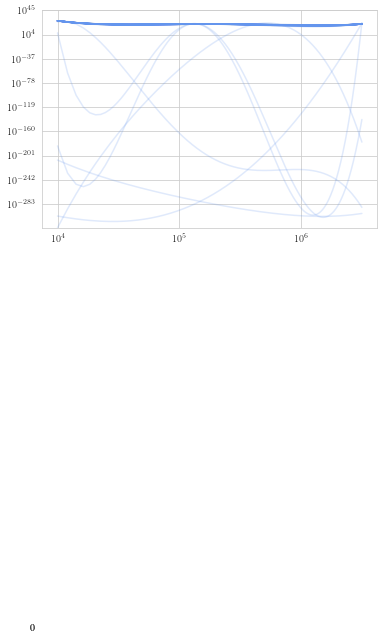

In [19]:
for i in range(0, sample_num):
    temp_psi_line = 10.0**chebval(log_temp, line_samples[np.random.choice(range(len(line_samples)))])
    if i == 0:
        plt.loglog(temp, temp_psi_line,
                    color=line_sample_color,
                    alpha=alpha, label=line_sample_label)
    else:
        plt.loglog(temp, temp_psi_line, color=line_sample_color, alpha=alpha)

plt.loglog(temp, line_psi, color=line_main_color, label=line_main_label)

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Temperature [K]')
y_label = r'$\Psi(T) = N_e N_{\mathrm{H}} \frac{ds}{dT}$ '
y_label += r'[cm$^{-5}$ K$^{-1}$]'
plt.ylabel(y_label)
plt.ylim(10.0**14.0, 10.0**28.0)
plt.title('Differential Emission Measure Fits of TRAPPIST-1\'s Corona')
plt.savefig('test_dem.pdf')
plt.show()

## Create and save model spectra from 1 - 2000 Angstroms

In [ ]:
'''
all_spectra = np.empty((sample_num, len(all_wave)))
all_psi = np.empty((sample_num, len(temp)))
np.random.shuffle(line_samples)

for i in range(0, sample_num):
    all_psi[i, :] = 10.0**chebval(log_temp, line_samples[i, :])
    all_spectra[i, :] = do_gofnt_matrix_integral(all_psi[i, :],
                                                 gofnt_matrix_all,
                                                 temp, flux_weighting)

np.save('spectra_lines_all', all_spectra)
np.save('psi_lines_all', all_psi)
'''

## Load model spectra

In [2]:
all_spectra = np.load('spectra_lines_all.npy')

## Plot model spectra

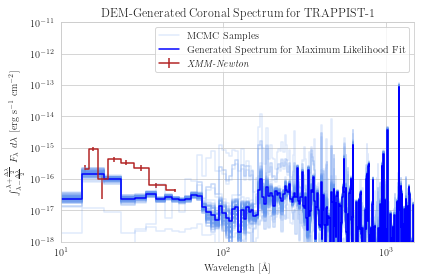

In [30]:
for i in range(0, sample_num):
    spectra = all_spectra[i]
    if i == 0:
        plt.semilogy(all_wave, spectra, color=line_sample_color,
                     alpha=alpha, label='MCMC Samples', drawstyle='steps-mid')
    else:
        plt.semilogy(all_wave, spectra, color=line_sample_color,
                     alpha=alpha, drawstyle='steps-mid')

best_spectra = do_gofnt_matrix_integral(line_psi, gofnt_matrix_all, temp, flux_weighting)
'''
plt.errorbar(fuv_wave1, fuv_flux1, yerr=fuv_err1,
             color=g130_color, drawstyle='steps-mid', label=r'G130M \emph{STIS}')

plt.errorbar(fuv_wave2, fuv_flux2, yerr=fuv_err2,
             color=g160_color, drawstyle='steps-mid', label=r'G160M \emph{STIS}')
'''
plt.errorbar(xray_wave, xray_flux, yerr=xray_err,
             color=xray_color, drawstyle='steps-mid', label=r'\emph{XMM-Newton}')

plt.semilogy(all_wave, best_spectra, color=line_main_color,
             label='Generated Spectrum for Maximum Likelihood Fit', drawstyle='steps-mid')

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel(r'Wavelength [\AA]')
y_label = r'$\int_{\lambda - \frac{\Delta \lambda}{2}}^{\lambda + \frac{\Delta \lambda}{2}}$ $F_\lambda$ $d\lambda$ [erg s$^{-1}$ cm$^{-2}$]'
plt.ylabel(y_label)
plt.title('DEM-Generated Coronal Spectrum for TRAPPIST-1')
plt.ylim(10.0**-18, 10**-11)
plt.gca().set_xscale('log')
# plt.xlim(1200, 1250)
# plt.xlim(0, 50)
plt.xlim(10, 1500)
plt.tight_layout()
plt.savefig('generated_spectrum.pdf')
plt.show()

In [ ]:
append_wave = np.append(xray_wave, fuv_wave)
test_spectra = do_gofnt_matrix_integral(line_psi, append_gofnt, temp, flux_weighting)

plt.errorbar(fuv_wave1, fuv_flux1, yerr=fuv_err1,
             color=g130_color, drawstyle='steps-mid', label=r'G130M \emph{STIS}')

plt.errorbar(fuv_wave2, fuv_flux2, yerr=fuv_err2,
             color=g160_color, drawstyle='steps-mid', label=r'G160M \emph{STIS}')

plt.errorbar(xray_wave, xray_flux, yerr=xray_err,
             color=xray_color, drawstyle='steps-mid', label=r'\emph{XMM-Newton}')

plt.semilogy(append_wave, test_spectra, color=line_main_color,
             label='Generated Spectrum for Maximum Likelihood Fit', drawstyle='steps-mid')

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel(r'Wavelength [\AA]')
y_label = r'$\int_{\lambda - \frac{\Delta \lambda}{2}}^{\lambda + \frac{\Delta \lambda}{2}}$ $F_\lambda$ $d\lambda$ [erg s$^{-1}$ cm$^{-2}$]'
plt.ylabel(y_label)
plt.title('DEM-Generated Coronal Spectrum for TRAPPIST-1')
plt.ylim(10.0**-18, 10**-14)
# plt.gca().set_xscale('log')
# plt.xlim(1290, 1500)
plt.xlim(0, 50)
# plt.savefig('generated_spectrum.pdf')
plt.show()

In [ ]:
plt.semilogy(fuv_wave1, fuv_flux1)
plt.semilogy(fuv_wave2, fuv_flux2)
plt.show()

In [ ]:
append_flux

In [ ]:
dem_intensities = do_gofnt_matrix_integral(line_psi, append_gofnt, temp, flux_weighting)

In [ ]:
print(dem_intensities)

In [ ]:
plt.loglog(dem_intensities/append_flux, '.')
plt.show()

In [ ]:
ion_temp_fs

In [14]:
targ_dist = 12.49 * u.pc
targ_rad = 0.121 * u.R_sun
targ_abundance = 0.04
flux_unit = u.erg / (u.second * (u.cm**2.0))
intensity_conversion = (targ_dist**2.0) / ((targ_rad**2.0) * np.pi * u.sr)
intensity_unit = u.erg / (u.second * u.sr * (u.cm**2.0))
flux_weighting = ((np.pi * u.sr * (targ_rad**2.0) * (1.0 / (targ_dist**2.0))).to(u.sr)).value

all_wave = np.arange(1.0, 2001.0, 5.0)
all_spectra = np.load('spectra_lines_all.npy')
line_samples = np.load('samples_line_all.npy')
line_lnprob = np.load('lnprob_line_all.npy')
gofnt_matrix_all = np.load('gofnt_matrix_all_trappist-1.npy')
line_psi = 10.0**chebval(log_temp, line_samples[np.argmax(line_lnprob)])
best_spectra = do_gofnt_matrix_integral(line_psi, gofnt_matrix_all, temp, flux_weighting)

wave_unit = u.Angstrom
flux_unit = u.erg / (u.s * u.cm**2)

err_spectra = np.std(all_spectra, axis=0)

from astropy.table import Table

trappist_spectra = Table([all_wave*wave_unit, best_spectra*flux_unit, err_spectra*flux_unit], names=('Wavelength', 'Bin-Integrated Flux', 'Error'))
trappist_spectra.write('trappist-1_dem_spectra.fits', format='fits')


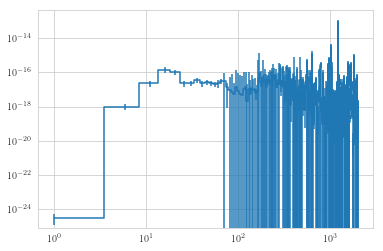

In [18]:
test_table = Table.read('trappist-1_dem_spectra.fits')
plt.errorbar(test_table['Wavelength'], test_table['Bin-Integrated Flux'], yerr=test_table['Error'], drawstyle='steps-mid')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')